In [1]:
%%capture
%pip install openmeteo-requests requests-cache retry-requests numpy pandas matplotlib torch scikit-learn scipy seaborn statsmodels seaborn timeseriesfcst tensorflow

# Setup


In [2]:
import openmeteo_requests
import requests_cache
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from retry_requests import retry
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import timeseriesfcst as tsfcst
import timeseriesfcst.feature_engineering as hffe

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2024-07-29 16:11:51.042023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 16:11:51.077927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 16:11:51.085245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 16:11:51.103158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 16:11:53.082723: W tensorflow/compiler/tf2

# Define Constants


In [3]:
# Constants
TRAIN_END = "2022-12-31"
VAL_START = "2023-01-01"
VAL_END = "2023-12-31"
TEST_START = "2024-01-01"

DATE_COL = "date"
SOLAR_PATH = "data/energy_charts.csv"


# Load Solar Data

In [4]:
# Load solar data
solar_ts = pd.read_csv("/home/moonchild/PycharmProjects/solar-prediction/data/energy_charts.csv", sep=",", header=0)
solar_ts["date"] = pd.to_datetime(solar_ts["Datum"], utc=True)
solar_ts.drop(columns=["Datum"], inplace=True)
solar_ts.set_index("date", inplace=True)

# Remove Duplicates

In [5]:
# Keep the first occurrence of each duplicate
solar_ts = solar_ts[~solar_ts.index.duplicated(keep='first')]
pd.Series(solar_ts.index.duplicated()).value_counts()

# Check for duplicates again
if solar_ts.index.duplicated().any():
    print("Duplicates found:")
    print(solar_ts[solar_ts.index.duplicated(keep=False)])

# Interpolate Missing timestamps

In [6]:
# Check for continuity
expected_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
missing_times = expected_range.difference(solar_ts.index)
if not missing_times.empty:
    print(f"Missing timestamps detected: {missing_times}")
    
# Create a full range of 15-min intervals
full_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
solar_ts = solar_ts.reindex(full_range)

# Interpolate missing values using time interpolation
solar_ts.interpolate(method='time', inplace=True)

Missing timestamps detected: DatetimeIndex(['2015-02-28 23:00:00+00:00', '2015-02-28 23:15:00+00:00',
               '2015-02-28 23:30:00+00:00', '2015-02-28 23:45:00+00:00',
               '2015-09-25 02:00:00+00:00', '2015-09-25 02:15:00+00:00',
               '2015-09-25 02:30:00+00:00', '2015-09-25 02:45:00+00:00',
               '2016-02-27 02:00:00+00:00', '2016-02-27 02:15:00+00:00',
               '2016-02-27 02:30:00+00:00', '2016-02-27 02:45:00+00:00',
               '2016-09-30 02:00:00+00:00', '2016-09-30 02:15:00+00:00',
               '2016-09-30 02:30:00+00:00', '2016-09-30 02:45:00+00:00',
               '2017-02-26 02:00:00+00:00', '2017-02-26 02:15:00+00:00',
               '2017-02-26 02:30:00+00:00', '2017-02-26 02:45:00+00:00',
               '2017-09-29 02:00:00+00:00', '2017-09-29 02:15:00+00:00',
               '2017-09-29 02:30:00+00:00', '2017-09-29 02:45:00+00:00',
               '2018-02-25 02:00:00+00:00', '2018-02-25 02:15:00+00:00',
               '2018-0

In [7]:
# Check for continuity
expected_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
missing_times = expected_range.difference(solar_ts.index)
if not missing_times.empty:
    print(f"Missing timestamps detected: {missing_times}")

# Resample from 15min to hourly sequences

In [8]:
# Resample
solar_ts = solar_ts.resample('h').sum()

# Set the frequency to the inferred frequency of the DataFrame index
solar_ts = solar_ts.asfreq(pd.infer_freq(solar_ts.index))
solar_ts

,Leistung
2014-12-31 23:00:00+00:00,0.0
2015-01-01 00:00:00+00:00,0.0
2015-01-01 01:00:00+00:00,0.0
2015-01-01 02:00:00+00:00,0.0
2015-01-01 03:00:00+00:00,0.0
...,...
2024-05-05 05:00:00+00:00,19682.8
2024-05-05 06:00:00+00:00,37439.6
2024-05-05 07:00:00+00:00,58640.1
2024-05-05 08:00:00+00:00,79882.7


# Load OMEO Weather Dataset for multivariate Model

In [9]:
# Set up the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required train variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
	"latitude": [53.1187, 50.0692, 51.9069, 48.7651, 50.9787, 54.0748],
	"longitude": [13.5022, 7.4415, 8.3785, 11.4237, 11.0328, 9.9819],
	"start_date": ["2014-01-01", "2014-01-01", "2014-01-01", "2014-01-01", "2014-01-01", "2014-01-01"   ],
	"end_date": ["2024-05-01", "2024-05-01", "2024-05-01", "2024-05-01", "2024-05-01", "2024-05-01"],
	"hourly": ["temperature_2m", "cloud_cover", "shortwave_radiation", "diffuse_radiation", "direct_normal_irradiance"],
	"timezone": ["Europe/Berlin", "Europe/Berlin", "Europe/Berlin", "Europe/Berlin", "Europe/Berlin", "Europe/Berlin"]
}

responses = openmeteo.weather_api(url, params=params)

# Process all locations
all_hourly_dataframes = []

for response in responses:
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    
    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
    hourly_shortwave_radiation = hourly.Variables(2).ValuesAsNumpy()
    hourly_diffuse_radiation = hourly.Variables(3).ValuesAsNumpy()
    hourly_direct_normal_irradiance = hourly.Variables(4).ValuesAsNumpy()    
    
    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["cloud_cover"] = hourly_cloud_cover
    hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
    hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
    hourly_data["direct_normal_irradiance"] = hourly_direct_normal_irradiance
    
    
    hourly_dataframe = pd.DataFrame(data = hourly_data)
    hourly_dataframe.set_index("date", inplace = True)
    
    # Add location information to the DataFrame
    # hourly_dataframe['latitude'] = response.Latitude()
    # hourly_dataframe['longitude'] = response.Longitude()
    
    all_hourly_dataframes.append(hourly_dataframe)

# Combine all DataFrames into a single DataFrame
combined_hourly_dataframe = pd.concat(all_hourly_dataframes, keys=range(len(all_hourly_dataframes)))

# Print the shape of the combined DataFrame to verify
print(f"Combined DataFrame shape: {combined_hourly_dataframe.shape}")
    

Coordinates 53.1107177734375°N 13.44045352935791°E
Elevation 64.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
Coordinates 50.08787155151367°N 7.395104885101318°E
Elevation 411.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
Coordinates 51.9156379699707°N 8.406593322753906°E
Elevation 79.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
Coordinates 48.752193450927734°N 11.421319961547852°E
Elevation 380.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
Coordinates 51.00175476074219°N 11.109123229980469°E
Elevation 199.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
Coordinates 54.09490203857422°N 9.961165428161621°E
Elevation 27.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
Combined DataFrame shape: (543456, 5)


# Quick Cleandup and improved readability

In [10]:
# Add "_city" to the column names in all_hourly_dataframes[0]
templin = all_hourly_dataframes[0].add_suffix("_templin")
kastellaun = all_hourly_dataframes[1].add_suffix("_kastellaun")
guetersloh = all_hourly_dataframes[2].add_suffix("_guetersloh")
ingolstadt = all_hourly_dataframes[3].add_suffix("_ingolstadt")
erfurt = all_hourly_dataframes[4].add_suffix("_erfurt")
neumunster = all_hourly_dataframes[5].add_suffix("_neumunster")

# Merge the DataFrames
hourly_dataframe = pd.concat([templin, kastellaun, guetersloh, ingolstadt, erfurt, neumunster], axis=1)
hourly_dataframe

,temperature_2m_templin,cloud_cover_templin,shortwave_radiation_templin,diffuse_radiation_templin,direct_normal_irradiance_templin,temperature_2m_kastellaun,cloud_cover_kastellaun,shortwave_radiation_kastellaun,diffuse_radiation_kastellaun,direct_normal_irradiance_kastellaun,...,temperature_2m_erfurt,cloud_cover_erfurt,shortwave_radiation_erfurt,diffuse_radiation_erfurt,direct_normal_irradiance_erfurt,temperature_2m_neumunster,cloud_cover_neumunster,shortwave_radiation_neumunster,diffuse_radiation_neumunster,direct_normal_irradiance_neumunster
date,,,,,,,,,,,,,,,,,,,,,
2013-12-31 22:00:00+00:00,0.119500,9.300000,0.0,0.0,0.000000,2.090000,55.200005,0.0,0.0,0.000000,...,-0.596500,50.400002,0.0,0.0,0.000000,2.576000,43.800003,0.0,0.0,0.000000
2013-12-31 23:00:00+00:00,-0.080500,22.200001,0.0,0.0,0.000000,2.290000,43.500000,0.0,0.0,0.000000,...,-0.396500,42.600002,0.0,0.0,0.000000,2.376000,49.800003,0.0,0.0,0.000000
2014-01-01 00:00:00+00:00,-0.080500,44.400002,0.0,0.0,0.000000,2.490000,81.300003,0.0,0.0,0.000000,...,-0.196500,47.400002,0.0,0.0,0.000000,2.176000,68.400009,0.0,0.0,0.000000
2014-01-01 01:00:00+00:00,-0.030500,38.100002,0.0,0.0,0.000000,2.440000,100.000000,0.0,0.0,0.000000,...,-0.096500,57.600002,0.0,0.0,0.000000,2.126000,68.400002,0.0,0.0,0.000000
2014-01-01 02:00:00+00:00,0.069500,45.300003,0.0,0.0,0.000000,2.590000,100.000000,0.0,0.0,0.000000,...,-0.246500,66.000000,0.0,0.0,0.000000,2.226000,61.200005,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 17:00:00+00:00,22.150000,29.700001,224.0,70.0,521.040222,20.898500,30.600002,216.0,154.0,173.953384,...,22.514000,32.700001,241.0,77.0,515.912415,18.913000,2.100000,267.0,72.0,590.822754
2024-05-01 18:00:00+00:00,20.700001,26.700001,86.0,43.0,294.102112,19.548500,31.800001,107.0,76.0,157.615311,...,20.614000,29.400002,100.0,48.0,324.337524,17.563000,28.800001,125.0,48.0,419.779388
2024-05-01 19:00:00+00:00,19.400000,8.100000,7.0,6.0,13.959738,17.548500,28.200003,20.0,14.0,63.593018,...,18.864000,20.700001,9.0,8.0,12.951038,16.063000,15.000001,20.0,13.0,76.648422


# Merge Solar and Weather Data

In [11]:
# merge with solar_ts
energy_ts = solar_ts.merge(hourly_dataframe, left_index=True, right_index=True, how='inner')
energy_ts.info()
energy_ts

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81815 entries, 2014-12-31 23:00:00+00:00 to 2024-05-01 21:00:00+00:00
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Leistung                             81815 non-null  float64
 1   temperature_2m_templin               81815 non-null  float32
 2   cloud_cover_templin                  81815 non-null  float32
 3   shortwave_radiation_templin          81815 non-null  float32
 4   diffuse_radiation_templin            81815 non-null  float32
 5   direct_normal_irradiance_templin     81815 non-null  float32
 6   temperature_2m_kastellaun            81815 non-null  float32
 7   cloud_cover_kastellaun               81815 non-null  float32
 8   shortwave_radiation_kastellaun       81815 non-null  float32
 9   diffuse_radiation_kastellaun         81815 non-null  float32
 10  direct_normal_irradiance_kastellaun  81815 non-

,Leistung,temperature_2m_templin,cloud_cover_templin,shortwave_radiation_templin,diffuse_radiation_templin,direct_normal_irradiance_templin,temperature_2m_kastellaun,cloud_cover_kastellaun,shortwave_radiation_kastellaun,diffuse_radiation_kastellaun,...,temperature_2m_erfurt,cloud_cover_erfurt,shortwave_radiation_erfurt,diffuse_radiation_erfurt,direct_normal_irradiance_erfurt,temperature_2m_neumunster,cloud_cover_neumunster,shortwave_radiation_neumunster,diffuse_radiation_neumunster,direct_normal_irradiance_neumunster
2014-12-31 23:00:00+00:00,0.0,3.919500,100.000000,0.0,0.0,0.000000,-1.110000,80.099998,0.0,0.0,...,2.603500,100.000000,0.0,0.0,0.000000,3.426000,54.000000,0.0,0.0,0.000000
2015-01-01 00:00:00+00:00,0.0,3.669500,73.800003,0.0,0.0,0.000000,-1.410000,84.900002,0.0,0.0,...,2.603500,100.000000,0.0,0.0,0.000000,3.476000,68.400002,0.0,0.0,0.000000
2015-01-01 01:00:00+00:00,0.0,3.369500,72.599998,0.0,0.0,0.000000,-1.710000,84.000000,0.0,0.0,...,2.553500,100.000000,0.0,0.0,0.000000,3.526000,83.699997,0.0,0.0,0.000000
2015-01-01 02:00:00+00:00,0.0,2.819500,52.500000,0.0,0.0,0.000000,-1.660000,83.099998,0.0,0.0,...,2.653500,100.000000,0.0,0.0,0.000000,3.776000,90.000000,0.0,0.0,0.000000
2015-01-01 03:00:00+00:00,0.0,2.169500,28.799999,0.0,0.0,0.000000,-1.910000,81.900002,0.0,0.0,...,2.653500,100.000000,0.0,0.0,0.000000,3.776000,90.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 17:00:00+00:00,14386.7,22.150000,29.700001,224.0,70.0,521.040222,20.898500,30.600002,216.0,154.0,...,22.514000,32.700001,241.0,77.0,515.912415,18.913000,2.100000,267.0,72.0,590.822754
2024-05-01 18:00:00+00:00,1648.6,20.700001,26.700001,86.0,43.0,294.102112,19.548500,31.800001,107.0,76.0,...,20.614000,29.400002,100.0,48.0,324.337524,17.563000,28.800001,125.0,48.0,419.779388
2024-05-01 19:00:00+00:00,1.5,19.400000,8.100000,7.0,6.0,13.959738,17.548500,28.200003,20.0,14.0,...,18.864000,20.700001,9.0,8.0,12.951038,16.063000,15.000001,20.0,13.0,76.648422
2024-05-01 20:00:00+00:00,0.0,18.549999,6.300000,0.0,0.0,0.000000,16.348499,10.800000,0.0,0.0,...,16.814001,6.000000,0.0,0.0,0.000000,14.912999,24.300001,0.0,0.0,0.000000


# Partition


In [12]:
# Split
train_ts = energy_ts[:TRAIN_END]  # Training data up to the end of 2022
val_ts = energy_ts[VAL_START:VAL_END]  # Validation data for the year 2023
test_ts = energy_ts[TEST_START:]  # Test data from the beginning of 2024 onwards

# Save to CSV


In [13]:
# Save to CSV with datetime index
train_ts.to_csv("data/train_ts.csv", header=True, index=True, index_label=False)
val_ts.to_csv("data/val_ts.csv", header=True, index=True, index_label=False)
test_ts.to_csv("data/test_ts.csv", header=True, index=True, index_label=False)

# Normalise

In [14]:
# noramlise train val and test data based on train data
train_mean = train_ts.mean()
train_std = train_ts.std()

train_ts = (train_ts - train_mean) / train_std
val_ts = (val_ts - train_mean) / train_std
test_ts = (test_ts - train_mean) / train_std

# Handle Leap Years


# 

In [15]:
# Check for duplicated dates
for ts in [train_ts, val_ts, test_ts]:
    if ts.index.duplicated().any():
        print("Duplicates found:")
        print(ts[ts.index.duplicated(keep=False)])

# Keep the first occurrence of each duplicate
for i, ts in enumerate([train_ts, val_ts, test_ts]):
    ts = ts[~ts.index.duplicated(keep='first')]
    if i == 0:
        train_ts = ts
    elif i == 1:
        val_ts = ts
    else:
        test_ts = ts

# Confirm that there are no duplicates anymore
for ts in [train_ts, val_ts, test_ts]:
    print(pd.Series(ts.index.duplicated()).value_counts())

False    70129
Name: count, dtype: int64
False    8760
Name: count, dtype: int64
False    2926
Name: count, dtype: int64


# **Decompose Time Series**

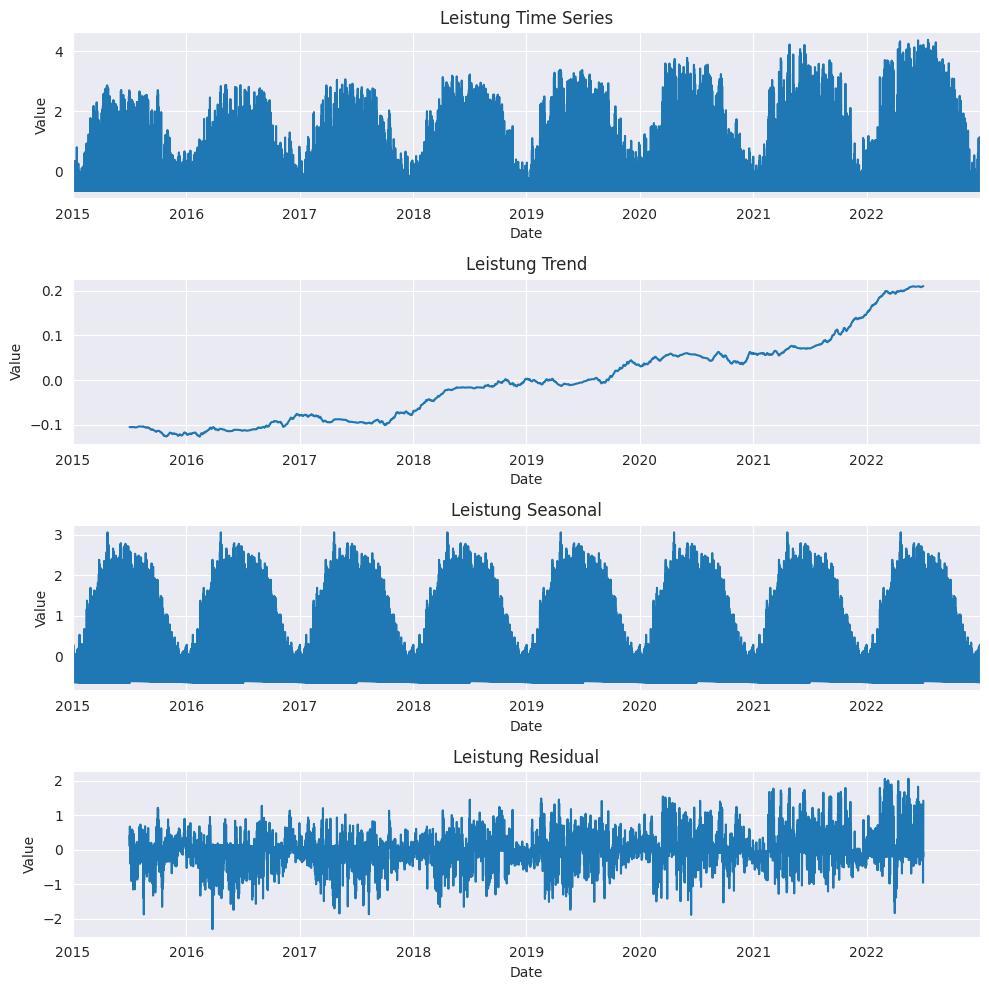

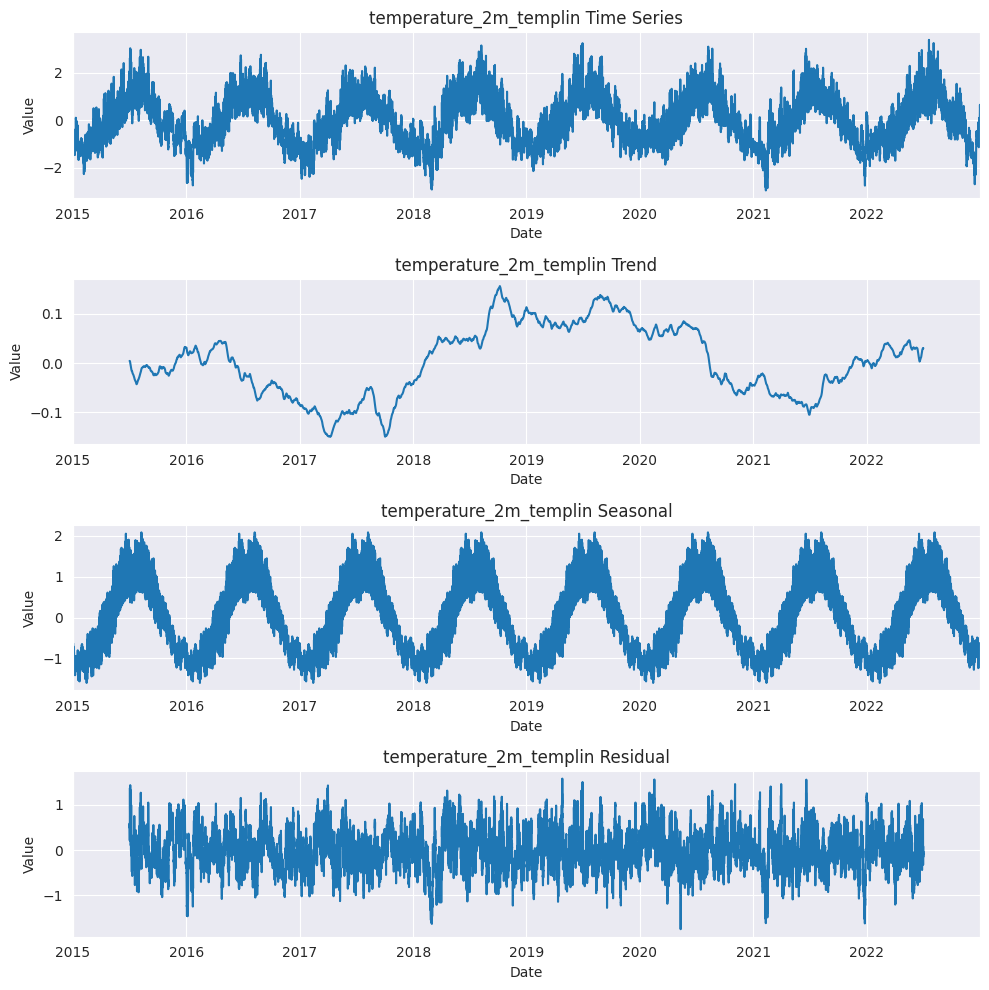

In [ ]:
# Plot and decompose each time series as grid of plots
for column in train_ts.columns:
    fig, axes = plt.subplots(4, 1, figsize=(10, 10))
    axes[0].set_title(f"{column} Time Series")
    train_ts[column].plot(ax=axes[0])
    axes[0].set_ylabel("Value")
    axes[0].set_xlabel("Date")
    axes[0].grid(True)
    
    decomposition = seasonal_decompose(train_ts[column], model='additive', period=8760)
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_title(f"{column} Trend")
    axes[1].set_ylabel("Value")
    axes[1].set_xlabel("Date")
    axes[1].grid(True)
    
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_title(f"{column} Seasonal")
    axes[2].set_ylabel("Value")
    axes[2].set_xlabel("Date")
    axes[2].grid(True)
    
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_title(f"{column} Residual")
    axes[3].set_ylabel("Value")
    axes[3].set_xlabel("Date")
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

# Test ACF and PACF

In [ ]:
# Check autocorrelation of each series in the training data and display as grid
for col in train_ts.columns:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(train_ts[col], ax=ax[0], lags=50, title=f'Autocorrelation of {col}')
    plot_pacf(train_ts[col], ax=ax[1], lags=50, title=f'Partial Autocorrelation of {col}')
    plt.show()

# MULTIVARIATE CORRELATION ANALYSIS

In [ ]:
# Scatter Plots (pairwise)
sns.pairplot(train_ts, diag_kind="kde")  
plt.show() 

# Sort features based on target variable correlation (absolute value)
sorted_features = train_ts.corr().iloc[0,:].abs().sort_values(ascending=False).index.tolist()

# Ordered heatmap 
corr_matrix = train_ts[sorted_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="twilight")  
plt.show()

# Correlation Matrix as df
print(corr_matrix.to_string())  # Print the correlation matrix as text

In [ ]:
# Granger Causality Tests for the series in train_ts
for col in train_ts.columns:
    for col2 in train_ts.columns:
        if col != col2:
            print(f'Granger Causality Test for {col} and {col2}')
            data = pd.concat([train_ts[col], train_ts[col2]], axis=1)
            max_lag = 12
            results = grangercausalitytests(data, max_lag, verbose=True)
            print("\n")  # Add a space between outputs

# LSTM


In [ ]:
# Create sequences
sequence_length = 24
batch_size = 8
target_column = 'Leistung'

X_train, y_train = tsfcst.lstm.create_sequences(train_ts, target_column, sequence_length, batch_size)
X_val, y_val = tsfcst.lstm.create_sequences(val_ts, target_column, sequence_length, batch_size)
X_test, y_test = tsfcst.lstm.create_sequences(test_ts, target_column, sequence_length, batch_size)

# Print the shapes
print("Training set - X shape:", X_train.shape, "y shape:", y_train.shape)
print("Validation set - X shape:", X_val.shape, "y shape:", y_val.shape)
print("Test set - X shape:", X_test.shape, "y shape:", y_test.shape)

In [ ]:
# LSTM model
def create_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.0001, loss='mse'):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

def train_lstm_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=8):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks= early_stopping, #[early_stopping, model_checkpoint],
        verbose=1
    )
    
    return history

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape)

# Train the model
history = train_lstm_model(model, X_train, y_train, X_val, y_val)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)


In [ ]:
# Plot train val losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot predictions 
plt.plot(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

# calculate performance metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return mae, mse, rmse, r2, mape

mae, mse, rmse, r2, mape = calculate_metrics(y_test, predictions)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}")

# Feature Importance 


In [ ]:
# Feature Importance
def permutation_importance(model, X, y, n_repeats=10):
    baseline_mse = mean_squared_error(y, model.predict(X))
    importances = []
    
    for column in range(X.shape[2]):  # Iterate over features
        feature_importances = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[:,:,column] = np.random.permutation(X_permuted[:,:,column])
            permuted_mse = mean_squared_error(y, model.predict(X_permuted))
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        importances.append(np.mean(feature_importances))
    
    return importances

# Calculate permutation importance
importances = permutation_importance(model, X_test, y_test)

# get feature names (column names)
feature_names = train_ts.columns

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance (Increase in MSE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print feature importance
print(importance_df)